In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import numpy as np


def get_device() -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    x = torch.ones(1, device=device)

    return device


def get_data() -> datasets.MNIST:
    transform = transforms.Compose(
        [
            # Converts to float and normalizes from [0, 255] to [0, 1]
            transforms.ToTensor(),
            # Flattens the 2D image 28x28 to 1D vector 784
            transforms.Lambda(lambda x: x.view(-1)),
        ]
    )

    train_set = datasets.MNIST("data/", download=True, train=True, transform=transform)
    return train_set


def batch_accuracy(x: torch.Tensor, y: torch.Tensor, model: nn.Module):
    """Compute accuracy for a batch of inputs"""
    model.eval()
    with torch.no_grad():
        predictions = model(x)
    return (predictions.argmax(dim=1) == y).cpu()

In [ ]:
device = get_device()
model = torch.load("Davids_MNIST_Model.pt", weights_only=False)
model.eval()
model = model.to(device)
train_data = get_data()
error_sums_per_class = torch.zeros((10, 28, 28), device=device)
class_counters = torch.zeros(10, device=device)
incorrectly_classified_image_count = 0
not_robust_count = 0
robust_count = 0

# Create DataLoader for batch processing
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False)

# Process batches with progress bar
for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
    images = images.to(device)
    labels = labels.to(device)

    # Update class counters
    class_counters.scatter_add_(
        0, labels, torch.ones_like(labels, dtype=torch.float)
    )

    # Check which samples are correctly classified
    correct_mask = batch_accuracy(images, labels, model)

    # Process only correctly classified samples
    correct_images = images[correct_mask]
    correct_labels = labels[correct_mask]
    incorrectly_classified_image_count += len(images) - len(correct_images)

    if len(correct_images) > 0:
        # Create all possible single-pixel perturbations
        pixel_perturbations = torch.eye(784, device=device)
        perturbed_images = correct_images.unsqueeze(
            1
        ) + pixel_perturbations.unsqueeze(0) * (1 - 2 * correct_images.unsqueeze(1))

        # Reshape for batch processing
        batch_labels = correct_labels.repeat_interleave(784)
        perturbed_images = perturbed_images.reshape(-1, 784)

        # Process perturbations in sub-batches to avoid memory issues
        sub_batch_size = 784
        for i in range(0, len(perturbed_images), sub_batch_size):
            sub_batch = perturbed_images[i : i + sub_batch_size]
            sub_labels = batch_labels[i : i + sub_batch_size]

            # Check which perturbations cause misclassification
            errors = ~batch_accuracy(sub_batch, sub_labels, model)

            # Update error sums
            error_indices = torch.nonzero(errors)
            error_count = len(error_indices)
            if error_count == 0:
                robust_count += 1
            else:
                not_robust_count += 1
            if len(error_indices) > 0:
                sample_idx = error_indices // 784
                pixel_idx = error_indices % 784
                labels_to_update = correct_labels[sample_idx]
                error_sums_per_class[
                    labels_to_update, pixel_idx // 28, pixel_idx % 28
                ] += 1
    
print(f"Incorrect: {incorrectly_classified_image_count} Robust: {robust_count} Not robust: {not_robust_count}")


100%|██████████| 938/938 [01:29<00:00, 10.48it/s]

Incorrect: 1863 Robust: 57375 Not robust: 762


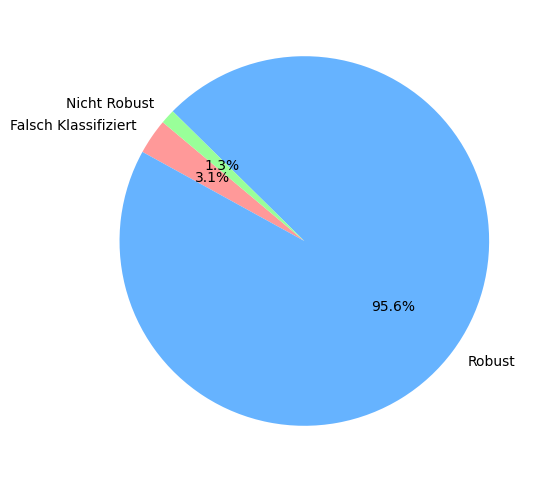

In [23]:
counts = [incorrectly_classified_image_count, robust_count, not_robust_count]
labels = ['Falsch Klassifiziert', 'Robust', 'Nicht Robust']
colors = ['#ff9999','#66b3ff','#99ff99']

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.show()

C:\Users\arthu\AppData\Local\Temp\ipykernel_26036\3834269907.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


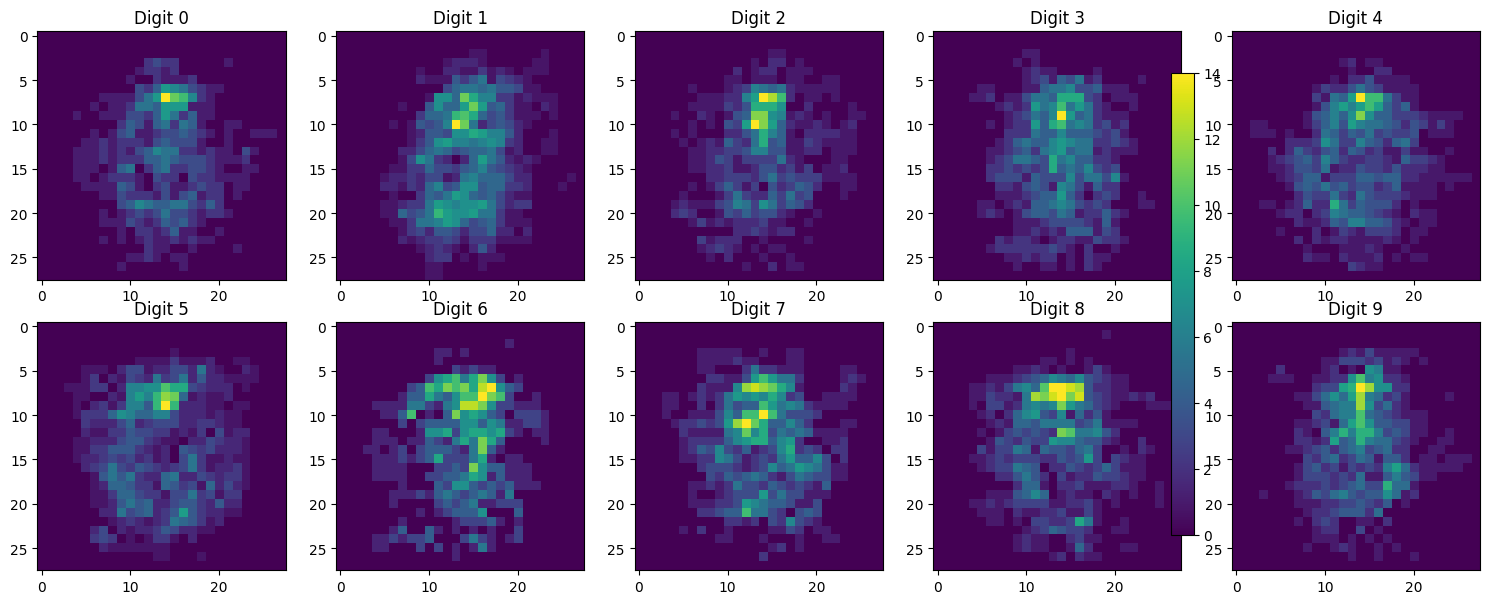

In [24]:
# Normalize error sums
_error_sums_per_class = error_sums_per_class / class_counters.reshape(-1, 1, 1)
_error_sums_per_class = error_sums_per_class.cpu().numpy()

# Plot results
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i // 5, i % 5]
    im = ax.imshow(_error_sums_per_class[i], interpolation="nearest")
    ax.set_title(f"Digit {i}")
plt.colorbar(im, ax=axes.ravel().tolist())
plt.tight_layout()
plt.show()